In [3]:
import pandas as pd
import pandas as pd
from sklearn import preprocessing
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style="white", palette="muted")
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [4]:
mypath = './data/training_data_set/'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [5]:
onlyfiles[-5:]

['20170303.pickle',
 '20170304.pickle',
 '20170305.pickle',
 '20170306.pickle',
 '20170308.pickle']

In [7]:
num_files = len(onlyfiles)
training_files, test_files = onlyfiles[:num_files - 20], onlyfiles[-3:]

In [8]:
df_array = []

for file_name in training_files:
    tmp_df = pd.read_pickle(mypath + file_name)
    df_array.append(tmp_df)
    
train_set = pd.concat(df_array,axis=0)

df_array = []

for file_name in test_files:
    tmp_df = pd.read_pickle(mypath + file_name)
    df_array.append(tmp_df)
    
test_set = pd.concat(df_array,axis=0)

In [9]:
# treshold 2 min is better
train_set

Route_route_short_name  \
TripState_at_datetime_ix Route_route_short_name_ix RealTime_miss_ix Trip_trip_id_ix            Stop_stop_id_ix      sequence_diff_ix stations_scheduled_trip_time_ix                          
20170201-04:30:00        C                         SARA             DUASN142442F04001-1_410649 StopPoint:DUA8754521 2.0              420.0                                                C   
                                                                                               StopPoint:DUA8754522 3.0              600.0                                                C   
                                                                                               StopPoint:DUA8754523 4.0              780.0                                                C   
                                                                    DUASN142446F04001-1_410648 StopPoint:DUA8754514 1.0              360.0                                                C   
                                                                                               StopPoint:DUA8754515 2.0              540.0                                                C   
                                                                                               StopPoint:DUA8754516 3.0              780.0                                                C   
                                                                                               StopPoint:DUA8754517 4.0              1020.0                                               C   
                                                                                               StopPoint:DUA8754518 5.0              1260.0                                               C   
                                                                                               StopPoint:DUA8754519 6.0              1680.0                                               C   
                                                                                               StopPoint:DUA8754520 7.0              1920.0                                               C   
                                                                                               StopPoint:DUA8754521 8.0              2040.0                                               C   
                                                                                               StopPoint:DUA8754522 9.0              2280.0                                               C   
                                                                                               StopPoint:DUA8754523 10.0             2400.0                                               C   
20170201-05:00:00        H                         AVOP             DUASN124600F01001-1_408621 StopPoint:DUA8727605 6.0              900.0                                                H   
                         D                         VOVA             DUASN126300F01003-1_412208 StopPoint:DUA8760880 9.0              1920.0                                               D   
                                                                                               StopPoint:DUA8768115 11.0             2280.0                                               D   
                                                                                               StopPoint:DUA8768124 10.0             2100.0                                               D   
                                                                                               StopPoint:DUA8768131 4.0              780.0                                                D   
                                                                                               StopPoint:DUA8768133 3.0              540.0                                                D   
                                                                                               StopPoint:DUA8768135 2.0              420.0                

In [7]:
train_set.columns

Index(['Route_route_short_name', 'last_observed_delay',
       'line_station_median_delay', 'line_median_delay', 'Trip_direction_id',
       'sequence_diff', 'stations_scheduled_trip_time',
       'rolling_trips_on_line', 'stoptime_scheduled_hour', 'RealTime_miss',
       'business_day', 'TripState_at_datetime', 'Route_route_short_name',
       'RealTime_miss', 'Trip_trip_id', 'Stop_stop_id', 'sequence_diff',
       'stations_scheduled_trip_time', 'label', 'label_ev', 'api_pred',
       'api_pred_ev', 'naive_pred', 'naive_pred_mae', 'naive_pred_mse'],
      dtype='object')

In [8]:
test_set.columns

Index(['Route_route_short_name', 'last_observed_delay',
       'line_station_median_delay', 'line_median_delay', 'Trip_direction_id',
       'sequence_diff', 'stations_scheduled_trip_time',
       'rolling_trips_on_line', 'stoptime_scheduled_hour', 'RealTime_miss',
       'business_day', 'TripState_at_datetime', 'Route_route_short_name',
       'RealTime_miss', 'Trip_trip_id', 'Stop_stop_id', 'sequence_diff',
       'stations_scheduled_trip_time', 'label', 'label_ev', 'api_pred',
       'api_pred_ev', 'naive_pred', 'naive_pred_mae', 'naive_pred_mse'],
      dtype='object')

### Simple Reg Lin

In [9]:
X_train = train_set[['last_observed_delay','line_station_median_delay','line_median_delay','sequence_diff'
           ,'stations_scheduled_trip_time','rolling_trips_on_line','sequence_diff','stations_scheduled_trip_time']].values
y_train = train_set.label.values
X_test = test_set[['last_observed_delay','line_station_median_delay','line_median_delay','sequence_diff'
           ,'stations_scheduled_trip_time','rolling_trips_on_line','sequence_diff','stations_scheduled_trip_time']].values
y_test = test_set.label.values

In [10]:
# SCALING
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Polynomial preprocessing: many features are correlated
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

In [12]:
from sklearn.linear_model import LinearRegression

cl = LinearRegression()
random_search = RandomizedSearchCV(
    cl,
    param_distributions ={"n_jobs":[-1]},
    n_iter=1,
    scoring='neg_mean_squared_error'
)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          fit_params={}, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'n_jobs': [-1]}, pre_dispatch='2*n_jobs',
          random_state=None, refit=True, return_train_score=True,
          scoring='neg_mean_squared_error', verbose=0)

In [13]:
# Uses best classifier
y_pred = random_search.predict(X_test)

# relu function
print("R2 score: %s" % r2_score(y_true=y_test, y_pred=y_pred))
print("Explained variance: %s" %
      explained_variance_score(y_test, y_pred))
print("Mean square error: %s" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %s" % mean_absolute_error(y_test, y_pred))

R2 score: 0.069890745623
Explained variance: 0.0701117944577
Mean square error: 67024.3034077
Mean absolute error: 107.767158593


### Getting only the low delays

In [14]:
#413882 ALL
#168036 TR = 60
treshold = 60
train_set_low = train_set[train_set['label'] < treshold]
test_set_low = test_set[test_set['label'] < treshold]

In [15]:
X_train = train_set_low[['last_observed_delay','line_station_median_delay','line_median_delay','sequence_diff'
           ,'stations_scheduled_trip_time','rolling_trips_on_line','sequence_diff','stations_scheduled_trip_time']].values
y_train = train_set_low.label.values
X_test = test_set_low[['last_observed_delay','line_station_median_delay','line_median_delay','sequence_diff'
           ,'stations_scheduled_trip_time','rolling_trips_on_line','sequence_diff','stations_scheduled_trip_time']].values
y_test = test_set_low.label.values

In [16]:
# SCALING
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Polynomial preprocessing: many features are correlated
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

In [18]:
from sklearn.linear_model import LinearRegression

cl = LinearRegression()
random_search_low = RandomizedSearchCV(
    cl,
    param_distributions ={"n_jobs":[-1]},
    n_iter=1,
    scoring='neg_mean_squared_error'
)
random_search_low.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          fit_params={}, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'n_jobs': [-1]}, pre_dispatch='2*n_jobs',
          random_state=None, refit=True, return_train_score=True,
          scoring='neg_mean_squared_error', verbose=0)

In [19]:
# Uses best classifier
y_pred = random_search_low.predict(X_test)

# relu function
print("R2 score: %s" % r2_score(y_true=y_test, y_pred=y_pred))
print("Explained variance: %s" %
      explained_variance_score(y_test, y_pred))
print("Mean square error: %s" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %s" % mean_absolute_error(y_test, y_pred))

R2 score: 0.619888569755
Explained variance: 0.620020033205
Mean square error: 5063.48241144
Mean absolute error: 29.6494081369


### Model for High delays

In [20]:
#413882 ALL
#168036 TR = 60
treshold = 60
train_set_high = train_set[train_set['label'] > treshold]
test_set_high = test_set[test_set['label'] > treshold]

In [21]:
X_train = train_set_high[['last_observed_delay','line_station_median_delay','line_median_delay','sequence_diff'
           ,'stations_scheduled_trip_time','rolling_trips_on_line','sequence_diff','stations_scheduled_trip_time']].values
y_train = train_set_high.label.values
X_test = test_set_high[['last_observed_delay','line_station_median_delay','line_median_delay','sequence_diff'
           ,'stations_scheduled_trip_time','rolling_trips_on_line','sequence_diff','stations_scheduled_trip_time']].values
y_test = test_set_high.label.values

In [22]:
# SCALING
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
# Polynomial preprocessing: many features are correlated
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)

In [24]:
from sklearn.linear_model import LinearRegression

cl = LinearRegression()
random_search_high = RandomizedSearchCV(
    cl,
    param_distributions ={"n_jobs":[-1]},
    n_iter=1,
    scoring='neg_mean_squared_error'
)
random_search_high.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          fit_params={}, iid=True, n_iter=1, n_jobs=1,
          param_distributions={'n_jobs': [-1]}, pre_dispatch='2*n_jobs',
          random_state=None, refit=True, return_train_score=True,
          scoring='neg_mean_squared_error', verbose=0)

In [25]:
# Uses best classifier
y_pred = random_search_high.predict(X_test)

# relu function
print("R2 score: %s" % r2_score(y_true=y_test, y_pred=y_pred))
print("Explained variance: %s" %
      explained_variance_score(y_test, y_pred))
print("Mean square error: %s" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %s" % mean_absolute_error(y_test, y_pred))

R2 score: 0.0296551451012
Explained variance: 0.0307063060188
Mean square error: 128671.069029
Mean absolute error: 169.679754724


---

# Verifying the delays difference

In [180]:
from os import path
from glob import glob

import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [181]:
###### CUSTOM PREDICTION COMPUTATION #######

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

In [182]:
# DATA IMPORT (after it has been loaded in temp file)
data_folder_path = './data/training_data_set/'
pickles = glob(path.join(data_folder_path, "*"))

In [183]:
# Day selection
start_date = "20170215"
end_date = "20170401"
dti = pd.date_range(start_date, end_date, freq="D")
days = dti.map(lambda x: x.strftime("%Y%m%d")).tolist()
pickles = [p for p in pickles if path.splitext(path.basename(p))[0] in days]

In [184]:
dfs = list(map(pd.read_pickle, pickles)) 
dfm = pd.concat(dfs) 
# problem saving duplicated columns 
dfm = dfm.loc[:, ~dfm.columns.duplicated()] 
# dfm["dt"] = pd.to_datetime(dfm.index.get_level_values(0))

In [185]:
def get_original_sel(dfm,lines):
    # SUBSAMPLE SELECTION
    sel = dfm.copy()
    #By line: selecting only some lines
    # lines = ['C', 'D', 'E', 'H', 'J', 'K', 'L', 'N', 'P', 'R', 'U']
    mask = sel.index.get_level_values("Route_route_short_name_ix").isin(lines)
    sel = sel[mask]
    
    # By sequence: selection only prediction for 1 to 10 stations ahead
    min_diff = 1
    max_diff = 40
    cond1 = (sel.index.get_level_values("sequence_diff_ix") >= min_diff)
    cond2 = (sel.index.get_level_values("sequence_diff_ix") <= max_diff)
    mask = cond1 & cond2
    sel = sel[mask]
    
    return sel
    
sel = get_original_sel(dfm,lines=["C"])

In [186]:
# By scheduled trip time:
scheduled_trip_filter = False
if scheduled_trip_filter:
    min_trip = 300
    max_trip = 4000
    cond1 = (sel["stations_scheduled_trip_time"] >= min_trip)
    cond2 = (sel["stations_scheduled_trip_time"] <= max_trip)
    mask = cond1 & cond2
    sel = sel[mask]
    # Only those that have a large delay
    min_delay = 180
    max_delay = 3000

In [187]:
dfm['label'].describe()

count    585907.000000
mean        119.398778
std         283.666450
min       -2220.000000
25%           0.000000
50%          60.000000
75%         120.000000
max       10200.000000
Name: label, dtype: float64

In [209]:
def trunk_on_delays(high_delay_filter=False,low_delay_filter=False,treshold=360,general=False):
    min_delay = 0
    max_delay = 0
    
    new_sel = sel
    
    if general == False:
        if low_delay_filter:
            min_delay = 0
            max_delay = treshold

        if high_delay_filter:
            min_delay = treshold
            max_delay = 10200

        cond1 = (sel["label"] >= min_delay)
        cond2 = (sel["label"] <= max_delay)
        mask = cond1 & cond2
        new_sel = sel[mask]
    
    return new_sel

sel = trunk_on_delays(high_delay_filter,low_delay_filter)

In [189]:
def show_scores(name, y_true, y_pred):
    print("%s R2 score: %s" % (name, r2_score(y_true=y_true, y_pred=y_pred)))
    print("%s Explained variance: %s" % (name,
                                         explained_variance_score(y_true, y_pred)))
    print("%s Mean square error: %s" % (name,
                                        mean_squared_error(y_true, y_pred)))
    print("%s Mean absolute error: %s" % (name,
                                          mean_absolute_error(y_true, y_pred)))

In [215]:
def get_scores(y_true, y_pred):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    evs = explained_variance_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2,evs,mse,mae

In [190]:
def get_X_y_yN(sel):
    _feature_cols = [
    # "Route_route_short_name", # condidering only C
    "last_observed_delay",
    "line_station_median_delay",
    "line_median_delay",
    "Trip_direction_id",
    "sequence_diff",
    "stations_scheduled_trip_time",
    "rolling_trips_on_line",
    #    "stoptime_scheduled_hour",
    #    "RealTime_miss",
    #"high_delay",
    "business_day"
    ]
    
    X = sel[_feature_cols]
    y_naive_pred = sel.naive_pred
    y = sel.label
    
    return X,y_naive_pred,y

In [191]:
# TEST SAMPLE
def get_Train_Test(sel):
    X,y_naive_pred,y = get_X_y_yN(sel)
    X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test = train_test_split(
        X, y, y_naive_pred,
        test_size=0.30, random_state=1
    )
    return X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test

X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test = get_Train_Test(sel)

In [192]:
# To keep initial state before preprocessing operations
def get_copies_train_test(X_train,X_test):
    X_train_ini = X_train.copy()
    X_test_ini = X_test.copy()
    
    return X_test_ini,X_test_ini

X_test_ini,X_test_ini = get_copies_train_test(X_train,X_test)

In [193]:
# SCALING
def scale_data(X_train, X_test, scale= False):
    X_train_new,X_test_new = X_train,X_test
    if scale:
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_new = pd.DataFrame(
            data=scaler.transform(X_train),
            index=X_train.index,
            columns=X_train.columns.values
        )
        X_test_new = pd.DataFrame(
            data=scaler.transform(X_test),
            index=X_test.index,
            columns=X_test.columns.values
        )
        
    return X_train_new,X_test_new
        
X_train,X_test = scale_data(X_train,X_test,scale=True)

In [194]:
# Polynomial preprocessing: many features are correlated
from sklearn.preprocessing import PolynomialFeatures

def polynomial_data_trans(X_train, X_test, polynomial= False):
    X_train_new,X_test_new = X_train,X_test
    if polynomial:
        poly = PolynomialFeatures(2)
        X_train_new = pd.DataFrame(
            data=poly.fit_transform(X_train),
            index=X_train.index,
            columns=poly.get_feature_names(X_train.columns)
        )
        X_test_new = pd.DataFrame(
            data=poly.fit_transform(X_test),
            index=X_test.index,
            columns=poly.get_feature_names(X_test.columns)
        )
        
    return X_train_new,X_test_new
        
X_train,X_test = polynomial_data_trans(X_train,X_test,polynomial=True)

In [461]:
#### Regression Here
def get_regressor(X_train,y_train):
    regr = LinearRegression(n_jobs=-1)
    regr.fit(X_train, y_train)
    
    return regr

from sklearn.linear_model import Ridge
def get_regressor_ridge(X_train,y_train):
    regr = Ridge(alpha=0.2)
    regr.fit(X_train, y_train)
    
    return regr

regr = get_regressor(X_train,y_train)
y_pred = regr.predict(X_test)

In [77]:
# Here, your predictions on the test subsample should be assigned
# to y_pred variable

# SCORES COMPARISON
# Score comparison between
show_scores(name="Custom Pred", y_true=y_test, y_pred=y_pred)
show_scores(name="Naive Pred", y_true=y_test, y_pred=y_naive_pred_test)

Custom Pred R2 score: 0.261943421446
Custom Pred Explained variance: 0.262279632767
Custom Pred Mean square error: 354044.294033
Custom Pred Mean absolute error: 418.710868354
Naive Pred R2 score: -1.68648078957
Naive Pred Explained variance: -0.282250058666
Naive Pred Mean square error: 1288699.56886
Naive Pred Mean absolute error: 846.056302308


In [196]:
def plot_comparaisons(sel,y_test,y_pred,name):
    comparison_df = pd.DataFrame(
        data={"r": y_test.values, "p": y_pred}, index=y_test.index)
    comparison_df["abs_error"] = np.abs(comparison_df.r - comparison_df.p)
    comparison_df["sqr_error"] = comparison_df["abs_error"]**2
    comparison_df = pd.concat([X_test_ini, comparison_df], axis=1)

    # PLOTS
    comparison_df.groupby(level=5).abs_error.mean().plot()
    sel.groupby(level="sequence_diff_ix")["naive_pred_mae"].mean().plot()
    plt.title("Prediction mean square error, per sequence_diff for " + name)
    plt.legend()
    plt.show()

In [146]:
if len(lines) > 1:
    comparison_df.groupby(level=1).abs_error.mean().plot(kind="bar")
    plt.title("Prediction mean square error, per line")
    plt.show()

    comparison_df.groupby(level=[1, 5]).abs_error.mean().unstack().T.plot()
    plt.title("Prediction mean square error, per line and sequence_diff")
    plt.show()

### Regrouping all the functions

In [462]:
# High Delays
sel = get_original_sel(dfm,lines=["C"])
sel = trunk_on_delays(high_delay_filter=True,low_delay_filter=False,treshold=360)
X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test = get_Train_Test(sel)
X_test_ini,X_test_ini = get_copies_train_test(X_train,X_test)
X_train,X_test = scale_data(X_train,X_test,scale=True)
#X_train,X_test = polynomial_data_trans(X_train,X_test,polynomial=True)
regr = get_regressor_ridge(X_train,y_train)
y_pred = regr.predict(X_test)
show_scores(name="High Delays Custom Pred", y_true=y_test, y_pred=y_pred)
show_scores(name="Naive Pred", y_true=y_test, y_pred=y_naive_pred_test)

High Delays Custom Pred R2 score: 0.137289311646
High Delays Custom Pred Explained variance: 0.137520456516
High Delays Custom Pred Mean square error: 327181.681474
High Delays Custom Pred Mean absolute error: 382.552658561
Naive Pred R2 score: -0.770184783111
Naive Pred Explained variance: -0.0945799527706
Naive Pred Mean square error: 671339.814929
Naive Pred Mean absolute error: 545.596545342


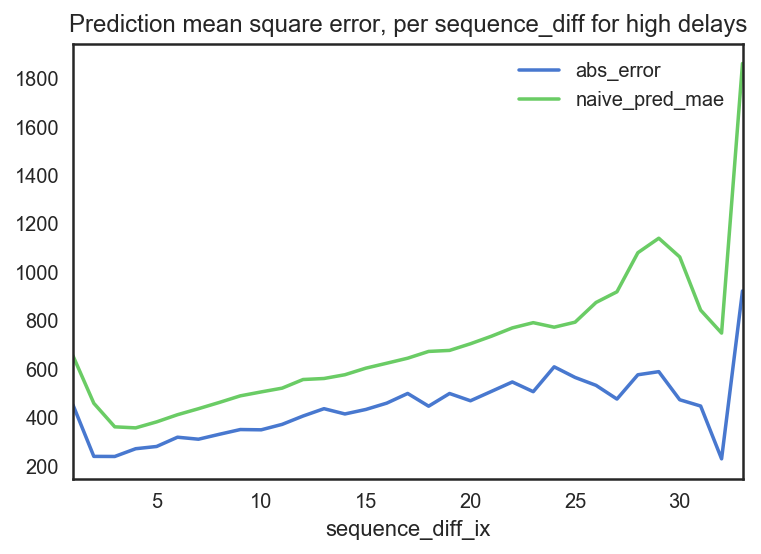

In [463]:
plot_comparaisons(sel,y_test,y_pred,name="high delays")

In [464]:
sel = get_original_sel(dfm,lines=["C"])
sel = trunk_on_delays(high_delay_filter=False,low_delay_filter=True,treshold=360)
X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test = get_Train_Test(sel)
X_test_ini,X_test_ini = get_copies_train_test(X_train,X_test)
X_train,X_test = scale_data(X_train,X_test,scale=True)
#X_train,X_test = polynomial_data_trans(X_train,X_test,polynomial=True)
y_pred = regr.predict(X_test)
show_scores(name="Low Delays Custom Pred", y_true=y_test, y_pred=y_pred)
show_scores(name="Naive Pred", y_true=y_test, y_pred=y_naive_pred_test)

Low Delays Custom Pred R2 score: -56.8137444556
Low Delays Custom Pred Explained variance: -3.63995538072
Low Delays Custom Pred Mean square error: 514050.605731
Low Delays Custom Pred Mean absolute error: 687.673299688
Naive Pred R2 score: -0.661036617885
Naive Pred Explained variance: -0.568354253334
Naive Pred Mean square error: 14769.0983797
Naive Pred Mean absolute error: 81.2411814869


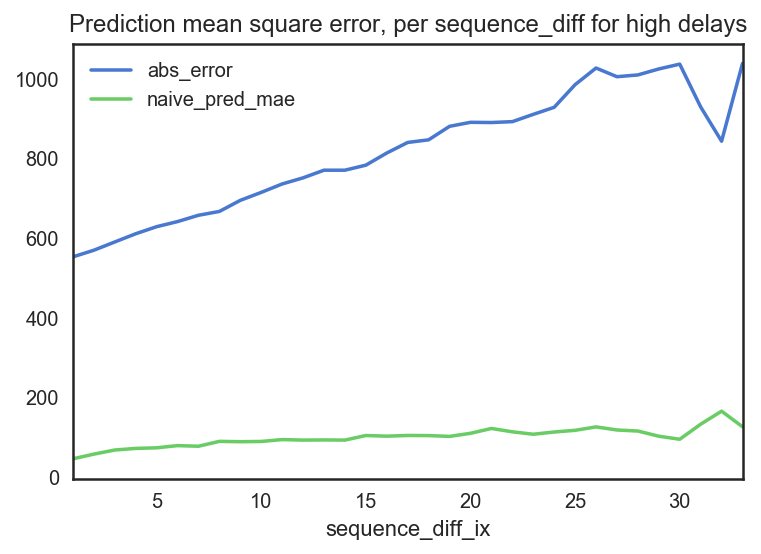

In [465]:
plot_comparaisons(sel,y_test,y_pred,name="high delays")

In [459]:
regr.coef_

array([ 130.30171621,    5.35056336,   47.9050763 ,  -55.52453655,
        138.01412668,  -17.87171406,  -96.11058002,  -11.15695933])

In [448]:
# Low Delays
sel = get_original_sel(dfm,lines=["C"])
sel = trunk_on_delays(high_delay_filter=False,low_delay_filter=True,treshold=360)
X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test = get_Train_Test(sel)
X_test_ini,X_test_ini = get_copies_train_test(X_train,X_test)
X_train,X_test = scale_data(X_train,X_test,scale=True)
X_train,X_test = polynomial_data_trans(X_train,X_test,polynomial=True)
regr = get_regressor(X_train,y_train)
y_pred = regr.predict(X_test)
show_scores(name="Low Delays Custom Pred", y_true=y_test, y_pred=y_pred)
show_scores(name="Naive Pred", y_true=y_test, y_pred=y_naive_pred_test)

Low Delays Custom Pred R2 score: 0.208972829571
Low Delays Custom Pred Explained variance: 0.208979639437
Low Delays Custom Pred Mean square error: 7033.4139388
Low Delays Custom Pred Mean absolute error: 65.2493340525
Naive Pred R2 score: -0.661036617885
Naive Pred Explained variance: -0.568354253334
Naive Pred Mean square error: 14769.0983797
Naive Pred Mean absolute error: 81.2411814869


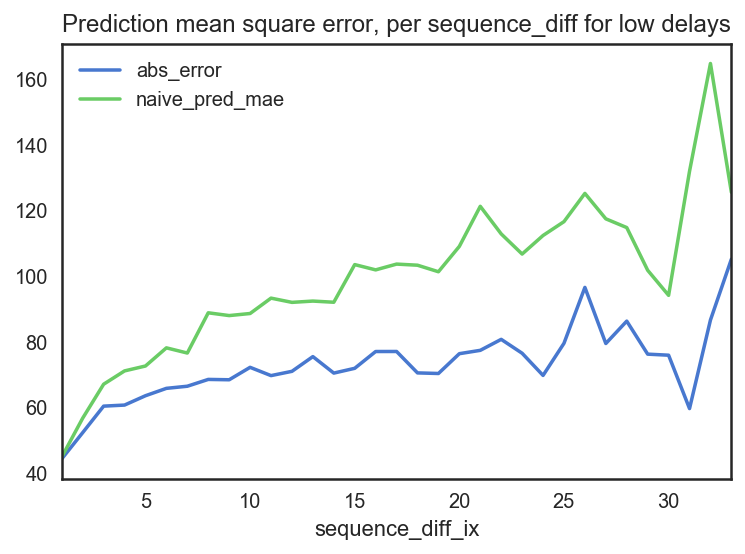

In [449]:
plot_comparaisons(sel,y_test,y_pred,name="low delays")

In [450]:
sel = get_original_sel(dfm,lines=["C"])
sel = trunk_on_delays(high_delay_filter=True,low_delay_filter=False,treshold=360)
X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test = get_Train_Test(sel)
X_test_ini,X_test_ini = get_copies_train_test(X_train,X_test)
X_train,X_test = scale_data(X_train,X_test,scale=True)
X_train,X_test = polynomial_data_trans(X_train,X_test,polynomial=True)
y_pred = regr.predict(X_test)
show_scores(name="Low Delays Custom Pred", y_true=y_test, y_pred=y_pred)
show_scores(name="Naive Pred", y_true=y_test, y_pred=y_naive_pred_test)

Low Delays Custom Pred R2 score: -2044589065.45
Low Delays Custom Pred Explained variance: -2044555126.62
Low Delays Custom Pred Mean square error: 7.75407210916e+14
Low Delays Custom Pred Mean absolute error: 14516682.2565
Naive Pred R2 score: -0.770184783111
Naive Pred Explained variance: -0.0945799527706
Naive Pred Mean square error: 671339.814929
Naive Pred Mean absolute error: 545.596545342


In [267]:
# General Regressor
sel = get_original_sel(dfm,lines=["C"])
sel = trunk_on_delays(general=True)
X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test = get_Train_Test(sel)
X_test_ini,X_test_ini = get_copies_train_test(X_train,X_test)
X_train,X_test = scale_data(X_train,X_test,scale=True)
X_train,X_test = polynomial_data_trans(X_train,X_test,polynomial=True)
regr = get_regressor(X_train,y_train)
y_pred = regr.predict(X_test)
show_scores(name="Low Delays Custom Pred", y_true=y_test, y_pred=y_pred)
show_scores(name="Naive Pred", y_true=y_test, y_pred=y_naive_pred_test)

Low Delays Custom Pred R2 score: 0.264160057812
Low Delays Custom Pred Explained variance: 0.264160541526
Low Delays Custom Pred Mean square error: 82842.1604698
Low Delays Custom Pred Mean absolute error: 141.76456845
Naive Pred R2 score: 0.0977059777552
Naive Pred Explained variance: 0.167938757666
Naive Pred Mean square error: 101581.854825
Naive Pred Mean absolute error: 140.470708796


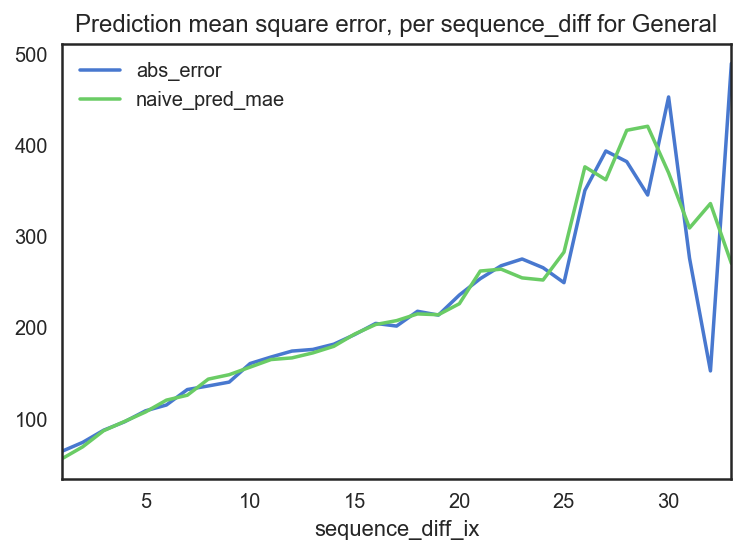

In [268]:
plot_comparaisons(sel,y_test,y_pred,name="General")

#### Comparaisons between tresholds

In [283]:
# Low Delays
def loop_get_scores(high,low,general=False):
    r2_array = []
    evs_array = []
    mse_array = []
    mae_array = []
    min_delay = 100
    max_delay = 4600
    step = 50
    steps = np.arange(min_delay,max_delay,step)
    
    for s in steps:
        sel = get_original_sel(dfm,lines=["C"])
        sel = trunk_on_delays(high_delay_filter=high,low_delay_filter=low,treshold=s,general=False)
        X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test = get_Train_Test(sel)
        X_test_ini,X_test_ini = get_copies_train_test(X_train,X_test)
        X_train,X_test = scale_data(X_train,X_test,scale=True)
        X_train,X_test = polynomial_data_trans(X_train,X_test,polynomial=True)
        regr = get_regressor(X_train,y_train)
        y_pred = regr.predict(X_test)
        r2,evs,mse,mae = get_scores(y_test,y_pred)
        
        r2_array.append(r2)
        evs_array.append(evs)
        mse_array.append(mse)
        mae_array.append(mae)
    
    scores_final = pd.DataFrame({'r2':r2_array, 'evs':evs_array, 'mse':mse_array, 'mae':mae_array},index=steps)
    return scores_final

In [303]:
scores = loop_get_scores(high=False,low=True)

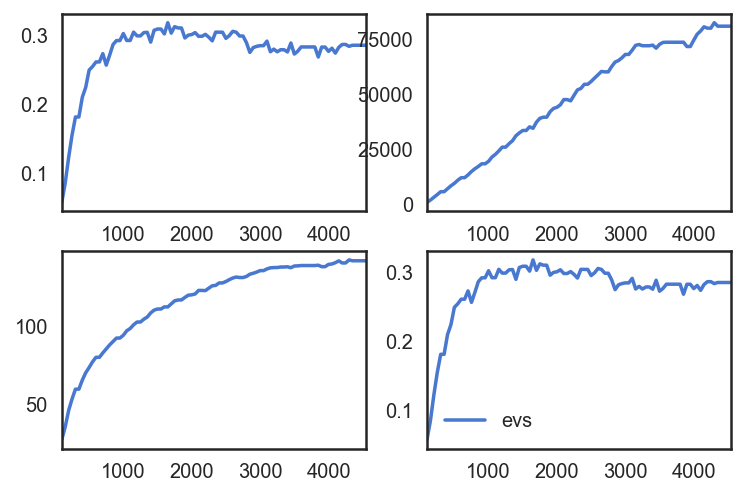

In [304]:
fig, axes = plt.subplots(nrows=2, ncols=2)
scores['r2'].plot(ax=axes[0,0])
scores['mse'].plot(ax=axes[0,1])
scores['mae'].plot(ax=axes[1,0])
scores['evs'].plot(ax=axes[1,1])
plt.legend()

### Delays classification

In [388]:
dfm_class = dfm.copy()

In [407]:
dfm_class['high_delay'] = dfm_class.apply(lambda row: 0 if row['label'] <= 360 else 1, axis=1)

In [423]:
dfm_class['hour'] = pd.to_datetime(dfm_class.index.get_level_values(0)).hour
dfm_class['day'] = pd.to_datetime(dfm_class.index.get_level_values(0)).dayofweek

In [424]:
def get_X_y_yN_classif(df):
    _feature_cols = [
    # "Route_route_short_name", # condidering only C
    "last_observed_delay",
    "line_station_median_delay",
    "line_median_delay",
    "Trip_direction_id",
    "sequence_diff",
    "stations_scheduled_trip_time",
    "rolling_trips_on_line",
    #    "stoptime_scheduled_hour",
    #    "RealTime_miss",
    "business_day",
    "day",
    "hour"
    ]
    
    X = df[_feature_cols]
    y_naive_pred = df.naive_pred
    y = df["high_delay"]
    
    return X,y_naive_pred,y

In [425]:
X,y_naive_pred,y = get_X_y_yN_classif(dfm_class)

In [426]:
def get_Train_Test_classif(sel):
    X,y_naive_pred,y = get_X_y_yN_classif(sel)
    X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test = train_test_split(
        X, y, y_naive_pred,
        test_size=0.30, random_state=1
    )
    return X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test

X_train, X_test, y_train, y_test, y_naive_pred_train, y_naive_pred_test = get_Train_Test_classif(dfm_class)

In [427]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score

In [428]:
rf = RandomForestClassifier(max_depth=5, n_estimators=50,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [438]:
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test.values, y_pred)

print("Accuracy",accuracy_score(y_test, y_pred))
print("Precision",average_precision_score(y_test, y_pred) )
print("F1 Score",f1_score(y_test, y_pred))
print("Recall Score",recall_score(y_test, y_pred))
print("Roc AUC Score",roc_auc_score(y_test, y_pred))

Accuracy 0.946908797142
Precision 0.547166605516
F1 Score 0.39181438999
Recall Score 0.261073475769
Roc AUC Score 0.628028503937


In [441]:
len(y_test)

175773

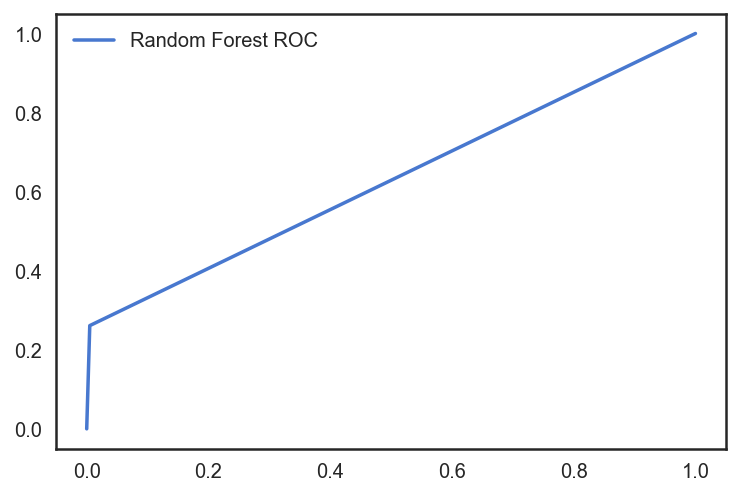

In [439]:
plt.plot(fpr_rf, tpr_rf,label="Random Forest ROC")
plt.legend()